0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


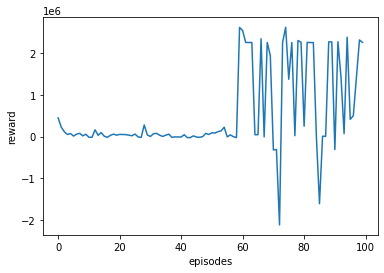

In [4]:
from simul_test import Sumobot

import random, sys
import numpy as np
from keras import Sequential
from collections import deque
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import math
import random
env = Sumobot()
np.random.seed(0)


class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space): #making the agent

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .997
        self.learning_rate = 0.001
        self.memory = deque(maxlen=100000)
        self.model = self.build_model()
        self.episode_coords = [0,0] # will be a 2x2 matrix
        self.angle = 0
        self.arena_radius = 44
        self.radius = -36
        self.angle_delta = 30 

    def build_model(self):
        model = Sequential() #groups a linear stack of layers into a model, provides training and inference features on this model
        model.add(Dense(64, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # once the random values chosen are starting to become larger
        # than the epsilon, the algorithm will start choosing values from the 
        # matrix that it has learnt.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space) #choose a random move
        act_values = self.model.predict(state) # Generates output predictions for the input samples.
        return np.argmax(act_values[0]) 

    def replay(self):
#         print(len(self.memory))
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose = 0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    

def train_dqn(episode):

    loss = []
    #sumobot and enemy action and state space
    action_space = 9
    state_space = 4
    max_steps = 750
    #sumobot agent
    agent = DQN(action_space, state_space)
    for e in range(episode):
        print(e)
        agent.episode_coords[0] = [random.randint(-30, 30), random.randint(-30, 30)]
        agent.episode_coords[1] = [random.randint(-30, 30), random.randint(-30, 30)]
        state = env.reset(agent.episode_coords)
        state = np.reshape(state, (1, state_space))
        score = 0             
                            
        for i in range(max_steps):
            action = agent.act(state)
            reward, next_state, done = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, state_space))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
#                 print("episode: {}/{}, score: {}".format(e, episode, score))
#                                     agent.model.summary()
                break
#                             agent.model.summary()
        loss.append(score) 
    #save both models
    agent.model.save('modelV4.h5')
    return loss


if __name__ == '__main__':
# So when the interpreter runs a module, the __name__ variable will be set as  __main__ if the module that is being run is the main program.
# But if the code is importing the module from another module, then the __name__  variable will be set to that module’s name.
# https://www.freecodecamp.org/news/if-name-main-python-example/
    ep = 100
    loss = train_dqn(ep)
#     print(loss)
    plt.plot([i for i in range(ep)], loss)
    plt.xlabel('episodes')
    plt.ylabel('reward')
    plt.show()